In [1]:
#@markdown ### **Imports**
# diffusion policy import
from typing import Tuple, Sequence, Dict, Union, Optional, Callable
import numpy as np
import math
import torch
import torch.nn as nn
import torchvision
import collections
import zarr
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from diffusers.training_utils import EMAModel
from diffusers.optimization import get_scheduler
from tqdm import tqdm
from PIL import Image
from skvideo.io import vwrite
from IPython.display import Video

# data imports
from  src.dataset import get_dataset_pusht
# model imports
from src.policy import get_action_diffusion_model, load_checkpoint 
# train import
from src.train import train_diff_model
# env import
from src.envs.sim_pusht import PushTImageEnv
# rollout import
from src.rollout import rollout

### Global Config Variables

In [2]:
dataset_path = 'demo/pusht_cchi_v7_replay.zarr.zip'
pred_horizon = 16
obs_horizon = 2
action_horizon = 8

device = "cuda"
encoder_name = "resnet18"
vision_feature_dim = 512
lowdim_obs_dim = 2
action_dim = 2

num_epochs = 100
batch_size = 64
num_workers = 4
num_diffusion_iters = 100

### Testing General Env

Creating PushT Env with seed 0.


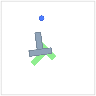

In [3]:
env = PushTImageEnv(seed=0)
obs, info = env.reset()
img = env.render(mode='rgb_array')
im = Image.fromarray(img)
im

### Testing dataset, model, and train functions

In [4]:
dataset, stats = get_dataset_pusht(dataset_path, pred_horizon, obs_horizon, action_horizon)

In [5]:
checkpoint_path = "demo/ema_100ep.pt"

nets = get_action_diffusion_model(
    device=device,
    encoder_name=encoder_name,
    vision_feature_dim=vision_feature_dim,
    lowdim_obs_dim=lowdim_obs_dim,
    action_dim=action_dim,
    obs_horizon=obs_horizon
)

load_checkpoint(model=nets, checkpoint_path=checkpoint_path, device=device)

number of parameters: 7.994727e+07
Loaded model from demo/ema_100ep.pt


In [6]:
logdir = "logs/train/test_default"

nets, losses = train_diff_model(
    nets=nets,
    dataset=dataset,
    logdir=logdir,
    num_epochs=num_epochs,
    batch_size=batch_size,
    num_workers=num_workers,
    device=device,
    num_diffusion_iters=num_diffusion_iters,
    obs_horizon=obs_horizon
)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]/home/woodbury/miniforge3/envs/sentinel/lib/python3.10/site-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
Epoch:   0%|          | 0/100 [00:03<?, ?it/s]


KeyboardInterrupt: 

### Testing the roll out code

In [7]:
# load the trained model
checkpoint_path = "demo/ema_100ep.pt"

nets = get_action_diffusion_model(
    device=device,
    encoder_name=encoder_name,
    vision_feature_dim=vision_feature_dim,
    lowdim_obs_dim=lowdim_obs_dim,
    action_dim=action_dim,
    obs_horizon=obs_horizon
)

load_checkpoint(model=nets, checkpoint_path=checkpoint_path, device=device)

# init the environment
env = PushTImageEnv(seed=100000)


rollout_data = rollout(ema_nets=nets,
                       env=env,
                       stats=stats,
                       max_steps=200,
                       obs_horizon=obs_horizon,
                       pred_horizon=pred_horizon,
                       device=device,
                       num_diffusion_iters=num_diffusion_iters,
                       action_dim=action_dim,
                       trajectory_sample_size=128)

# visualize the video
imgs = rollout_data['images']

vwrite('vis.mp4', imgs)
Video('vis.mp4', embed=True, width=256, height=256)

number of parameters: 7.994727e+07
Loaded model from demo/ema_100ep.pt
Creating PushT Env with seed 100000.


Eval PushTImageEnv:  62%|██████▏   | 124/200 [00:13<00:08,  9.42it/s, reward=1]     


In [8]:
# check the length of each key in the data
for k, v in rollout_data.items():
    print(k, len(v))

timesteps 124
images 124
rewards 124
sampled_trajectories 124
actions 124
agent_positions 124
agent_velocities 124
block_poses 124
goal_poses 124
step_image_features 124
